In [1]:
import pennylane as qml
from pennylane import numpy as npq
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pennylane.optimize import NesterovMomentumOptimizer

# --- Load and prepare the data ---
data = load_breast_cancer()
X = data.data
y = data.target

# Normalize to [0, π] for angle encoding
scaler = MinMaxScaler(feature_range=(0, npq.pi))
X_scaled = scaler.fit_transform(X)

# Use only the first N features to match the number of qubits
n_qubits = 8
X_scaled = X_scaled[:, :n_qubits]  # Let's keep it simple: 8 features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = npq.array(y_train)
y_test = npq.array(y_test)

# --- Quantum circuit ---
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_model(x, weights):
    half = len(x) // 2

    # Angle encoding (RY)
    for i in range(half):
        qml.RY(x[i], wires=i)

    # Parametric phase encoding (RZ)
    for i in range(half, len(x)):
        qml.RZ(x[i], wires=i)

    # Trainable entangling layers
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return qml.expval(qml.PauliZ(0))

# --- Prediction function ---
def predict(X, weights):
    preds = npq.array([quantum_model(x, weights) for x in X])
    return (preds + 1) / 2  # Rescale from [-1, 1] to [0, 1]

# --- Loss function (MSE) ---
def compute_loss(weights, X, y):
    preds = predict(X, weights)
    return npq.mean((preds - y) ** 2)

# --- Training ---
weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_qubits)
weights = 0.01 * npq.random.randn(*weights_shape)

opt = NesterovMomentumOptimizer(stepsize=0.5)
epochs = 20
losses = []

for epoch in range(epochs):
    weights, loss = opt.step_and_cost(lambda w: compute_loss(w, X_train, y_train), weights)
    losses.append(loss)
    print(f"Epoch {epoch + 1:02d} | Loss: {loss:.4f}")


Epoch 01 | Loss: 0.1866
Epoch 02 | Loss: 0.1773
Epoch 03 | Loss: 0.1646
Epoch 04 | Loss: 0.1505
Epoch 05 | Loss: 0.1373
Epoch 06 | Loss: 0.1272
Epoch 07 | Loss: 0.1210
Epoch 08 | Loss: 0.1183
Epoch 09 | Loss: 0.1182
Epoch 10 | Loss: 0.1195
Epoch 11 | Loss: 0.1214
Epoch 12 | Loss: 0.1229
Epoch 13 | Loss: 0.1237
Epoch 14 | Loss: 0.1237
Epoch 15 | Loss: 0.1231
Epoch 16 | Loss: 0.1222
Epoch 17 | Loss: 0.1212
Epoch 18 | Loss: 0.1202
Epoch 19 | Loss: 0.1193
Epoch 20 | Loss: 0.1186


In [2]:
from sklearn.metrics import accuracy_score

# Predict test data
y_pred = predict(X_test, weights)
y_pred_labels = (y_pred > 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test, y_pred_labels)
print(f"\nTest accuracy: {acc:.3f}")



Test accuracy: 0.895


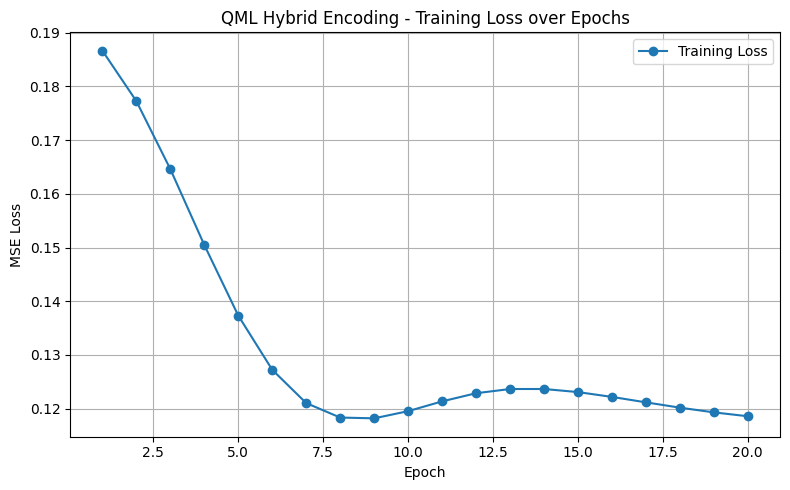

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o', label="Training Loss")
plt.title("QML Hybrid Encoding - Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Test Accuracy: 0.8947


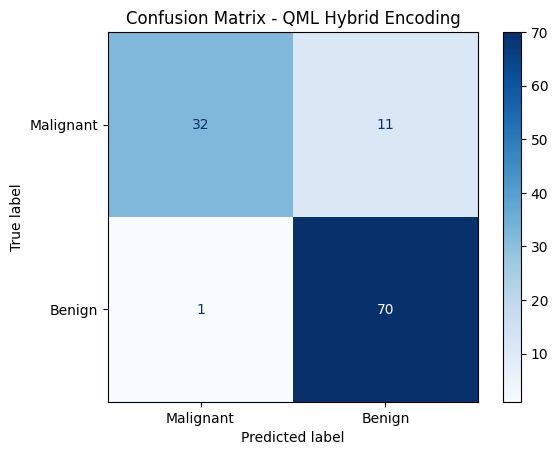

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Get predicted labels
y_pred_probs = predict(X_test, weights)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - QML Hybrid Encoding")
plt.show()


In [ ]:
accuracies = []

for epoch in range(epochs):
    weights, loss = opt.step_and_cost(lambda w: compute_loss(w, X_train, y_train), weights)
    losses.append(loss)

    # Accuracy on train set
    y_train_pred = predict(X_train, weights)
    acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
    accuracies.append(acc)

    print(f"Epoch {epoch + 1:02d} | Loss: {loss:.4f} | Acc: {acc:.4f}")


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), accuracies, marker='s', color='darkorange', label="Training Accuracy")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
